In [4]:
import pandas as pd
import datetime as dt
import random
import sys,os
import traceback

from enum import Enum
import pickle
import dill
from matplotlib.lines import Line2D
from textwrap import fill
import matplotlib.pyplot  as plt
import numpy as np


COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c',
          '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#7f7f7f', '#bcbd22', '#17becf']
LINEWIDTH_DEFAULT=2

# AP_path = "C:/Users/tong.wang/桌面/SAE_PlotTool/SAE_PlotTool/AP_Acoustic Response_all_xlsx.xlsx"
AP_path = "C:/Users/tong.wang/桌面/SAE_PlotTool/SAE_PlotTool/data/AP_RubAndBuzz.xlsx"
AP_path2 = "C:/Users/tong.wang/桌面/SAE_PlotTool/SAE_PlotTool/data/SPL1_THD.xlsx"
AP_path3 = "C:/Users/tong.wang/桌面/SAE_PlotTool/SAE_PlotTool/data/AP_Impedance_Sequence_all_xlsx.xlsx"

LEAP_path = "C:/Users/tong.wang/桌面/SAE_PlotTool/SAE_PlotTool/data/LEAP_Impedance.txt"
KLIPPEL_path = "C:/Users/tong.wang/桌面/SAE_PlotTool/SAE_PlotTool/data/NFS_CEA2034.txt"

In [21]:
class Extended_Enum(Enum):
    @classmethod
    def list(cls):
        return list(map(lambda c: c.value, cls))

    @classmethod
    def index(cls, _type):
        return list(cls).index(_type)

class CurveType(Extended_Enum):
    NoType = 'None'
    SPL = 'SPL'
    IMP = 'Impedance'
    PHS = 'Phase'
    THD = 'THD'
    EXC = 'Excursion'
    ALL = 'All'
    

def determineTypeByTestName(test_name):
    if ("Phase" in test_name):
        return CurveType.PHS
    elif ("Impedance" in test_name):
        return CurveType.IMP
    elif ("SPL" in test_name or "CEA" in test_name or 'RMS' in test_name):
        return CurveType.SPL
    elif ("THD" in test_name):
        return CurveType.THD
    else:
        return CurveType.NoType


In [17]:
class Project():
    def __init__(self, name="Untitled"):
        self.info = {
            "Name": name,
            "File Location": sys.path[0],
            'Create Time': dt.datetime.today().strftime("%Y/%m/%d %H:%M:%S"),
            'Last Saved Time': dt.datetime.today().strftime("%Y/%m/%d %H:%M:%S"),
        }
        self.files = []
        self.ui_conf = UI_CONF

    def print(self):
        print("\nProject: =================")
        print("Name: %s \nFile location: %s" %
              (self.info["Name"], self.get_path()))
        for _f in self.files:
            _f.print()
        print("============================\n")

    def append_file(self, file):
        self.files.append(file)

    def delete_files(self, files):
        for _f in files:
            self.files.remove(_f)

    def clear_files(self):
        self.files = []

    def get_path(self):
        return self.info['File Location'] + '/' + self.info['Name'] + '.pkl'

    def dump(self, location=None):
        if not location:
            location = self.get_path()
        # update curveData

        self.print()
        try:
            with open(location, 'wb') as fh:
                self.info["Last Saved Time"] = dt.datetime.today().strftime(
                    "%Y/%m/%d %H:%M:%S")
                pickle.dump(self, fh)
        except:
            print(dill.detect.baditems(self))

    @classmethod
    def load_project(cls, location=None):
        print("unpickled project:")
        print("location: ", location)
        if location == "None":
            return Project()
        else:
            try:
                fh = open(location, 'rb')
                # with open(f"%s.pkl" % (location), 'rb') as fh:
                unpickled_project = pickle.load(fh)
                if location is not unpickled_project.info["File Location"]:
                    print(
                        "WARNING: File location not the same --> change project info.")
                    unpickled_project.info["File Location"] = location
                unpickled_project.print()
                print("____________finish obj_data.Project.load_project()")
                fh.close()
                return unpickled_project
            except Exception as e:
                return Project()

    def update_ui_conf(self):
        self.ui_conf["MyCanvas"]["mode"] = self.wg_canvas.mode
        for mode, canvas_set in self.wg_canvas.status.items():
            self.ui_conf["MyCanvas"]["status"][mode] = [
                _c.id for _c in canvas_set]
        for _c in self.wg_canvas.canvasPool:
            self.ui_conf["MyCanvas"]["canvasPool"][str(_c.id)]["types"] = [
                _t.value for _t in _c.ax_types]
            self.ui_conf["MyCanvas"]["canvasPool"][str(
                _c.id)]["parameter"] = _c.parameter
        # with open("ui_conf.json", "w") as fj:
        #     json.dump(self.ui_conf, fj)
        # print("update_ui_conf", self.ui_conf)

    def get_files(self, filenames):
        files_to_return = []
        for _f in self.files:
            if _f.info["Name"] in filenames and _f not in files_to_return:
                files_to_return.append(_f)
        return files_to_return

In [16]:
class Measurement:
    '''
    The 3rd level of data structure.

    :ivar int id: index of this measurement.
    :ivar List(Channel) channel: a list of Channel instances in this Measurement instance.
    '''

    def __init__(self, channel_count=1, id=None):
        self.id = id
        self.channel = []
        self.init_channels(channel_count)

    def init_channels(self, count: int) -> None:
        """
        Create given numbers of Channel instances for this Measurement instance.

        :param int count: Total numbers of channels.
        """
        for i in range(count):
            self.channel.append(Channel(self, i+1))

    def print(self, console=True):
        """Print the infomation."""
        msg = ""
        msg += f"Measurement____id={self.id}\n"

        for c in self.channel:
            msg += "%s" % c.print(False)
        if (console):
            print(msg)
        return msg

class Channel:
    '''
    The 4th level of data structure.

    :ivar Measurement measurement_obj: The Measurement instance this Channel instance belongs to.
    :ivar int id: Channel's id.
    :ivar Dict sequence: A dictionary of testname and its corresponding CurveData instance.
    '''

    def __init__(self, measurement_obj=None, id=None):
        self.measurement_obj = measurement_obj
        self.id = id
        self.sequence = {}

    def print(self, console=True):
        """Print the infomation."""
        msg = f"Channel____id={self.id}\n"
        msg += "  Sequence:\n"
        for test, curve in self.sequence.items():
            msg += f"\t{test}: {curve}\n"
        if (console):
            print(msg)
        return msg

In [8]:
class FileData():
    '''
    The 2nd level of data structure.
    It contains general infomation of an imported files.

    :ivar Dict info: general infomation including name, source, file path, create time, last modified time.
    :ivar List(str) testnames: a list of all testnames.
    :ivar List(str) valid_testnames:
            a list of testnames that is visible and operatable in app, which is customized by user.
    :ivar Dict measurements: user interface configuration.
    '''

    def __init__(self, name=None, source=None, file_path=None, import_time=None):
        self.info = {
            "Name": name,
            "Source": source,
            "File Path": file_path,
            'Import Time': import_time,
            'Last Modified Time': dt.datetime.today().strftime("%Y/%m/%d %H:%M:%S"),
        }
#### Undo #####
        self.testnames = []
        self.valid_testnames = []
        self.measurements = {}

    def get_import_time(self) -> str:
        "Return imported time of this FileData instance."
        return self.info["Import Time"].strftime("%Y/%m/%d %H:%M:%S")

    def append_measurement(self, m_idx: int, measurement) -> None:
        """
        Append a measurement to this FileData instance.

        :param int m_idx: Index of the measurement.
        :param Measurement measurement: Given Measurement instance.
        """
        self.measurements[str(m_idx)] = measurement

#### Undo #####
    def __setstate__(self, state):
        self.__dict__.update(state)
        print(state)
        # Add baz back since it doesn't exist in the pickle
        # if "valid_testnames" not in self.__dict__.keys():
        #     self.valid_testnames = self.testnames

    def print(self):
        """Print the infomation of this FileData instance."""
        msg = "------------"
        msg += ("\n\tName: %s \n\tSource: %s \n\tfile_path: %s" %
                (self.info["Name"], self.info["Source"], self.info["File Path"]))
        msg += ("\n\tImport time: %s" % str(self.get_import_time()))
        msg += "\n\tSequence:"
        # for _k, _v in self.sequence.items():
        #     msg += ("\n\t  Key: %s" % _k)
        #     msg += ("\n\t  Curves: ")
        #     for _c in _v:
        #         msg += (f"\n\t\t%s, %s, %s" %
        #                 (_c.type.value, _c.label, _c.note))
        for _m in self.measurements.values():
            msg += _m.print()
        msg += ("\n-----------------------------")
        print(msg)
        return msg

In [23]:
class CurveData:
    '''
    The bottom (5th) level of data structure.

    :ivar Channel channel_obj: The Channel instance this CurveData instance belongs to.
    :ivar List(float) xdata: Curve's data of x-axis.
    :ivar List(float) ydata: Curve's data of y-axis.
    :ivar str label: Curve's label.
    :ivar str note: Curve's note.
    :ivar CurveType _type: Curve's data category.
    :ivar List(str) units: Units of xdata and ydata.
    :ivar float shifted: Recorded offset value.
    :ivar matplotlib.lines.Line2D line: Matplolib Line2D object created by this CurveData instance.
    :ivar Dict line_props: style properties of ``line``.
    '''

    def __init__(self, xdata, ydata, channel_obj, label: str = "Curve", note: str = "",
                 _type=CurveType.NoType, units=[]):
        self.channel_obj = channel_obj
        self.xdata = xdata
        self.ydata = ydata
        self.label = label
        self.note = note
        self.type = _type
        self.units = units
        self.shifted = 0
        self.line = None
        self.line_props = {
            "visible": False,
            "color": "",
            "linewidth": LINEWIDTH_DEFAULT,
        }

  # Get and Set Function
    def get_legend(self, legend_wrap: int) -> str:
        """
        Return the legend wrapped with a given characters long.

        :param int legend_wrap: A given number .
        """
        return fill(self.label, legend_wrap)

    def create_line2D(self, canvas, ax_id, order, legend_wrap, color=None, linewidth=LINEWIDTH_DEFAULT):
        """
        Plot a curve on given canvas's axis with specific order, text-wrap and color.

        :param matplotlib.figure canvas: Given matplot figure.
        :param int ax_id: Id of axis.
        :param int order: Figure would plot each curve by this order.
        :param str color: Curve's color.
        :param float linewidth: Curve's linewidth.
        """
        # print("create_line2D")
        ax = canvas.fig.axes[ax_id]
        if ax_id == 0:
            linecount = len(ax.lines)-2  # two initial draggable cross lines
        else:
            linecount = len(ax.lines)
        if not color:
            if self.line_props["color"]:
                color = self.line_props["color"]
            else:
                color = COLORS[linecount % 10]
        if self.line_props["linewidth"]:
            linewidth = self.line_props["linewidth"]

        ydata = [d+self.shifted for d in self.ydata]
        self.line, = ax.plot(self.xdata, ydata,
                             label=self.get_legend(legend_wrap), color=color,
                             linewidth=linewidth, picker=True)
        self.line.set_zorder(order)
        return self.line

  # Unary Post-processing
    def shift(self, offset: float):
        """
        Shift ydata with given offset, which is always compared with the original data.
        That is, if the given offset is zero, it would be the original curve.

        :param float offset: Given offset.
        """
        xdata, ydata = self.line.get_data()
        new_ydata = [d+(offset-self.shifted) for d in ydata]
        self.line.set_data(xdata, new_ydata)
        self.shifted += (offset-self.shifted)

    def align(self, targetDB, freq):
        """
        Shift the curve to align given magnitude at given frequency.

        :param float targetDB: The target y-magnitude to align.
        :param float freq: The target x-magnitude to align.
        """
        xdata, ydata = self.line.get_data()
        (index, freq) = min(enumerate(xdata), key=lambda x: abs(x[1]-freq))
        offset = targetDB - ydata[index]
        self.shift(offset)

  # Class Function
    def __getstate__(self):
        state = self.__dict__.copy()
        # Don't pickle attribute line, which includes package Matplotlib.
        del state["line"]
        return state

    def __setstate__(self, state):
        self.__dict__.update(state)
        self.line = None

    def print(self, console=True) -> str:
        """Print the infomation."""
        msg = (f"%s, %s, %s, line = {bool(self.line)}" % (
            self.type.value, self.label, self.note))
        if console:
            print(msg)
        return msg

In [19]:
AP_TEST_FILTERS = ["Impulse Response", "Window", "Thiele-Small", "Summary"]

def load_AP_fileData(path):
    filename = path[path.rfind('/')+1:path.rfind('.')]
    filedata = None
    if path.endswith('.xlsx') and os.path.exists(path):
        excel_data = pd.read_excel(path, engine="openpyxl", sheet_name=None)
        filedata = FileData(filename, source="AP", file_path=path,
                            import_time=dt.datetime.today())

        first_page = list(excel_data.keys())[0]
        channel_count = int(len(excel_data[first_page].columns)/2)

        measurements_count = 0
        test_in_sequence = list(excel_data.keys())[0]
        for count, page in enumerate(excel_data.keys()):
            test_name = excel_data[page].columns[0].strip()
            print("test_name", test_name, test_name not in test_in_sequence)
            if test_name not in test_in_sequence:
                measurements_count = count
                test_in_sequence = []
                break
        print(list(excel_data.keys()))
        test_in_sequence = list(excel_data.keys())[::measurements_count]
        print("test_in_sequence", test_in_sequence)
        test_in_sequence = [t for t in test_in_sequence if t not in AP_TEST_FILTERS]
        print("test_in_sequence", test_in_sequence)
        print("measurements_count", measurements_count)
        print("channel_count", channel_count)
        filedata.testnames = test_in_sequence
        filedata.valid_testnames = test_in_sequence
        for m_idx in range(measurements_count):
            measurementData = Measurement(
                channel_count=channel_count, id=m_idx+1)
            for page in list(excel_data.keys())[m_idx::measurements_count]:
                test_name = excel_data[page].columns[0].strip()
                print(page, test_name, test_name not in test_in_sequence)
                if test_name not in test_in_sequence:
                    continue
                _type = determineTypeByTestName(test_name)
                note = excel_data[page].columns[1].strip()
                isline = True

                for _idx in range(channel_count):
                    label = excel_data[page].iloc[0, _idx*2].strip()
                    curve_x = pd.Series(
                        excel_data[page].iloc[3:, _idx*2], name='x', dtype=float)
                    curve_y = pd.Series(
                        excel_data[page].iloc[3:, _idx*2+1], name='y', dtype=float)
                    units = [excel_data[page].iloc[2, _idx*2],
                             excel_data[page].iloc[2, _idx*2+1]]
                    if (curve_x.dtype != float or curve_y.dtype != float):
                        isline = False
                        continue

                    curveData = CurveData(curve_x, curve_y, channel_obj=measurementData.channel[_idx],
                                          label=label, note=note, _type=_type, units=units)
                    measurementData.channel[_idx].sequence[test_name] = curveData
            if (not isline and test_name in test_in_sequence):
                print(f"{test_name} is not float type and cannot be plot.")
                test_in_sequence.remove(test_name)
                continue
            filedata.append_measurement(m_idx, measurementData)
    else:
        pass
    return filedata

In [26]:
ap = load_AP_fileData(AP_path)

test_name Distortion Product Level False
test_name Distortion Product Level False
test_name Distortion Product Level False
test_name Distortion Product Level False
test_name Level and Distortion True
['Distortion Product Level', 'Distortion Product Level (1)', 'Distortion Product Level (2)', 'Distortion Product Level (3)', 'Level and Distortion', 'Level and Distortion (1)', 'Level and Distortion (2)', 'Level and Distortion (3)', 'Distortion Product Ratio ', 'Distortion Product Ratio (1)', 'Distortion Product Ratio (2)', 'Distortion Product Ratio (3)', 'Rub and Buzz Peak Ratio', 'Rub and Buzz Peak Ratio (1)', 'Rub and Buzz Peak Ratio (2)', 'Rub and Buzz Peak Ratio (3)', 'Summary']
test_in_sequence ['Distortion Product Level', 'Level and Distortion', 'Distortion Product Ratio ', 'Rub and Buzz Peak Ratio', 'Summary']
test_in_sequence ['Distortion Product Level', 'Level and Distortion', 'Distortion Product Ratio ', 'Rub and Buzz Peak Ratio']
measurements_count 4
channel_count 2
Distortion 

In [11]:
def load_KLIPPEL_fileData(path):
    filedata = None
    if path.endswith('.txt'):
        with open(path, 'r', encoding='UTF-8') as file:
            filename = path[path.rfind('/')+1:path.rfind('.')]
            filedata = FileData(filename, source="KLIPPEL",
                                file_path=path, import_time=dt.datetime.today())

            headers = file.readlines()[:3]
            if headers[0][0] == '%':
                raise Exception(
                    "file header start with %, it is a comsole file")
            test_name = headers[0].strip().strip('"')
            labels = headers[1].split('\t\t')
            labels = [c.replace('"', '').strip() for c in labels]

            unit_arr = headers[2].split('\t')
            unit_arr = [c.replace('"', '').strip() for c in unit_arr]

            data = pd.read_table(path,  skiprows=2)
            data = data.dropna()
            curveDatas = []
            note = ""

            # freq = data.iloc[:, 0]
            # freq = [float(f.replace(',', '').strip()) for f in freq]
            # freq = pd.Series(freq, name='x', dtype=float)

            _type = determineTypeByTestName(test_name)

            for i in range(int(len(data.columns)/2)):
                val = pd.Series(data.iloc[:, i*2+1], name='y', dtype=float)
                freq = data.iloc[:, i*2]
                freq = [float(f.replace(',', '').strip()) for f in freq]
                freq = pd.Series(freq, name='x', dtype=float)
                # 'Frequency [Hz]', 'Sound Pessure Level [dB]  / [2.83V 1m]'
                unit_x = unit_arr[i*2]
                unit_y = unit_arr[i*2+1]
                unit_x = unit_x[unit_x.find('['):unit_x.rfind(']')+1]
                unit_y = unit_y[unit_y.find('['):unit_y.rfind(']')+1]

                units = [unit_x, unit_y]  # ['[Hz]', '[dB]  / [2.83V 1m]']
                filename = unit_arr[i*2][unit_arr[i *
                                                  2].rfind('[')+1:path.rfind(']')]

                curveData_new = CurveData(
                    label=labels[i], note=note, xdata=freq, ydata=val, _type=_type, color=COLORS[i % 10], units=units)

                curveDatas.append(curveData_new)

            if test_name in filedata.sequence:
                pass
            else:
                filedata.sequence[test_name] = []
            filedata.sequence[test_name].extend(curveDatas)
    else:
        pass
    return filedata

In [12]:
def load_LEAP_fileData(path):
    filedata = None
    if path.endswith('.txt'):
        with open(path, 'r', encoding='UTF-8', errors='ignore') as file:
            headers = file.readlines()[:11]
            # LEAP_Impedance
            filename = path[path.rfind('/')+1:path.rfind('.')].strip()
            test_name = filename
            filedata = FileData(filename, source="LEAP",
                                file_path=path, import_time=dt.datetime.today())

            # Impedance_PR: T201100003660
            label = headers[4][headers[4].find('=')+1:].strip()

            units = headers[-1]
            units = units.strip().split(" ")
            units = [x for x in units if x][2:]     # ['Hz', 'Ohm', 'Deg']

            data = pd.read_csv(path,  skiprows=11)
            freq = pd.Series(data.iloc[:, 0], name='x', dtype=float)
            val = pd.Series(data.iloc[:, 1], name='y', dtype=float)
            phase = pd.Series(data.iloc[:, 2], name='y', dtype=float)

            note = ""

            _type = determineTypeByTestName(test_name)

            curveData_val = CurveData(
                label=label, note=note, xdata=freq, ydata=val, _type=_type, color=COLORS[0], units=[units[0], units[1]])

            curveData_phase = CurveData(
                label=label, note=note, xdata=freq, ydata=phase, _type=CurveType.PHS, color=COLORS[1], units=[units[0], units[2]])

            filedata.sequence[test_name] = [curveData_val]
            filedata.sequence["Phase"] = [curveData_phase]
            file.close()
    else:
        pass
    return filedata

In [13]:
def load_COMSOL_fileData(path):
    filedata = None
    if path.endswith('.txt'):
        with open(path, 'r', encoding='UTF-8', errors='ignore') as file:
            headers = file.readlines()[:8]
            filename = path[path.rfind('/')+1:path.rfind('.')]
            test_name = filename
            filedata = FileData(filename, source="COMSOL",
                                file_path=path, import_time=dt.datetime.today())

    #         label = headers[4][headers[4].find('=')+1:]   # Impedance_PR: T201100003660

    #         units = headers[-1]
    #         units = units.strip().split(" ")
    #         units = [x for x in units if x][2:]     # ['Hz', 'Ohm', 'Deg']

            data = pd.read_table(path,  skiprows=7, delim_whitespace=True)
    #         print(data.iloc[:,0])
            freq = pd.Series(data.iloc[:, 0], name='x', dtype=float)
            val = pd.Series(data.iloc[:, 1], name='y', dtype=float)
            # print(freq, val)

            note = ""
            curveData_new = CurveData(
                label=test_name, note=note, xdata=freq, ydata=val, _type=CurveType.SPL, color=COLORS[0])

            filedata.sequence[test_name] = [curveData_new]
            file.close()
    else:
        pass
    return filedata

In [63]:
ap1 = load_AP_fileData(AP_path)

c:\users\tong.wang\appdata\local\programs\python\python37\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


excel_data
 {'RMS Level -> Smooth':     RMS Level -> Smooth default (cardiod)    Unnamed: 2 Unnamed: 3
0                   Ch1               NaN           Ch2        NaN
1                     X                 Y             X          Y
2                    Hz              Vrms            Hz       Vrms
3                18.375               0.0        18.375        0.0
4               20.2125               0.0       20.2125        0.0
..                  ...               ...           ...        ...
460         18910.91171               0.0   18910.91171        0.0
461        19177.778379               0.0  19177.778379        0.0
462        19448.411013               0.0  19448.411013        0.0
463        19722.862755               0.0  19722.862755        0.0
464          20001.1875               0.0    20001.1875        0.0

[465 rows x 4 columns], 'RMS Level -> Smooth (1)':     RMS Level -> Smooth Bio-directional    Unnamed: 2 Unnamed: 3
0                   Ch1             NaN    

In [64]:
ap2 = load_AP_fileData(AP_path2)

excel_data
 {'SPL_Test':          SPL_Test          0
0             Ch1        NaN
1               X          Y
2              Hz      dBSPL
3        19.53125  69.369832
4       21.484375  69.419471
..            ...        ...
973  19701.171875  97.901075
974     19703.125  97.890733
975  19900.390625  97.023344
976   19902.34375   97.01359
977         20000   96.50978

[978 rows x 2 columns], 'THD Ratio':       THD Ratio          0
0           Ch1        NaN
1             X          Y
2            Hz          %
3        15.625   97.81292
4       23.4375  65.305836
..          ...        ...
699  19695.3125          0
700   19703.125          0
701  19898.4375          0
702    19906.25          0
703       20000          0

[704 rows x 2 columns], 'Summary':     Summary: Active.Nearfield.SPL_Test                   0          Unnamed: 2
0                              Channel  Passed Lower Limit  Passed Upper Limit
1                                  Ch1                 NaN             

In [16]:
ap1.print()

AttributeError: 'NoneType' object has no attribute 'print'

In [34]:
ap_smallscale.sequence["RMS Level -> Smooth"][0].ydata
curveData = ap_smallscale.sequence["RMS Level -> Smooth"][0]

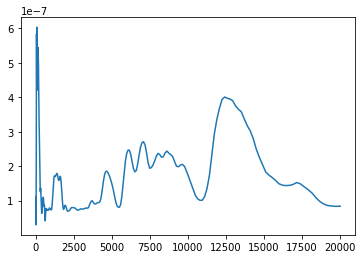

In [35]:
fig, ax = plt.subplots(1, )
ax.plot(curveData.xdata, curveData.ydata)
